In [1]:
import os

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchinfo import summary

from smlm_dl import dataset, model, trainer, util
import numpy as np
import skimage

/gpfs/ysm/home/kkc29/repos/smlm-dl/smlm_dl/dataset.py:441: RuntimeWarning: invalid value encountered in log
  im = axes[1].imshow(np.log(tiled_images))


2459:	 [id = 2459.000,], [A = 726.960, 847.141, 745.875, 923.178,], [bg = 21.660,], [x = -5.372, 13.193, 10.459, -7.576,], [y = 15.531, 9.668, -7.882, -5.098,], [z = 0.000, 0.000, 0.000, 0.000,], [sig_x = 5.000, 5.000, 5.000, 5.000,], [sig_y = 5.000, 5.000, 5.000, 5.000,],
3859:	 [id = 3859.000,], [A = 1743.002, 1450.168, 1257.334, 1807.525,], [bg = 17.767,], [x = 11.440, -15.596, 3.379, 3.987,], [y = -3.609, 15.923, 3.548, 2.153,], [z = 0.000, 0.000, 0.000, 0.000,], [sig_x = 5.000, 5.000, 5.000, 5.000,], [sig_y = 5.000, 5.000, 5.000, 5.000,],
3299:	 [id = 3299.000,], [A = 702.766, 1922.468, 840.010, 1650.067,], [bg = 63.019,], [x = -4.916, 0.411, -6.703, 5.643,], [y = 10.391, 14.201, -1.263, -6.985,], [z = 0.000, 0.000, 0.000, 0.000,], [sig_x = 5.000, 5.000, 5.000, 5.000,], [sig_y = 5.000, 5.000, 5.000, 5.000,],
2140:	 [id = 2140.000,], [A = 1747.348, 520.825, 1581.476, 1956.527,], [bg = 65.316,], [x = 14.262, -6.381, 5.492, -10.605,], [y = -8.729, 8.775, -0.268, -0.657,], [z = 0.000,

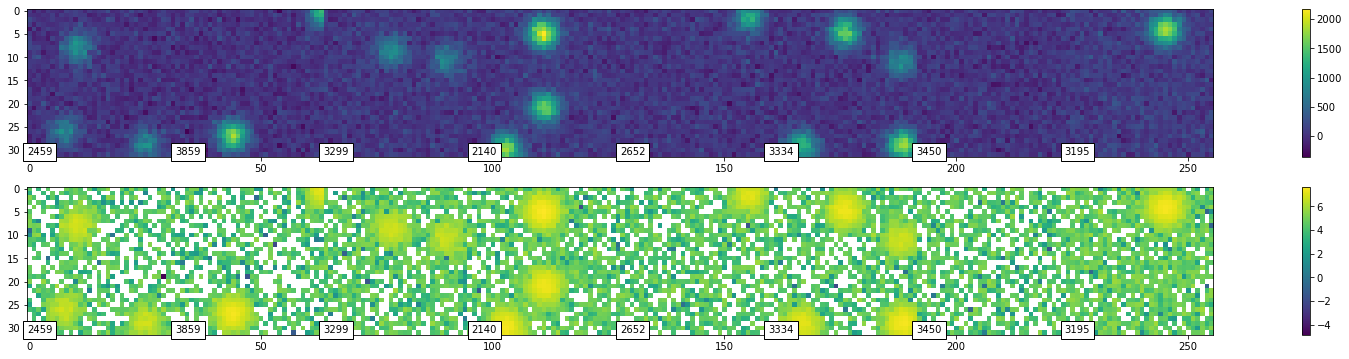

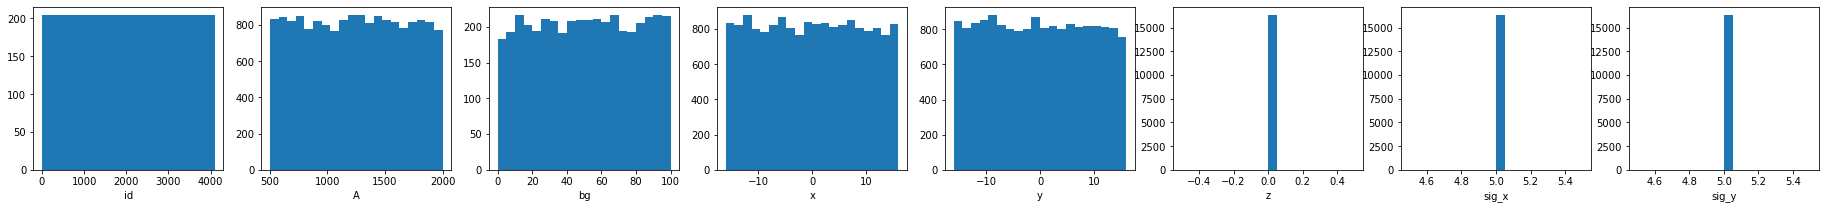

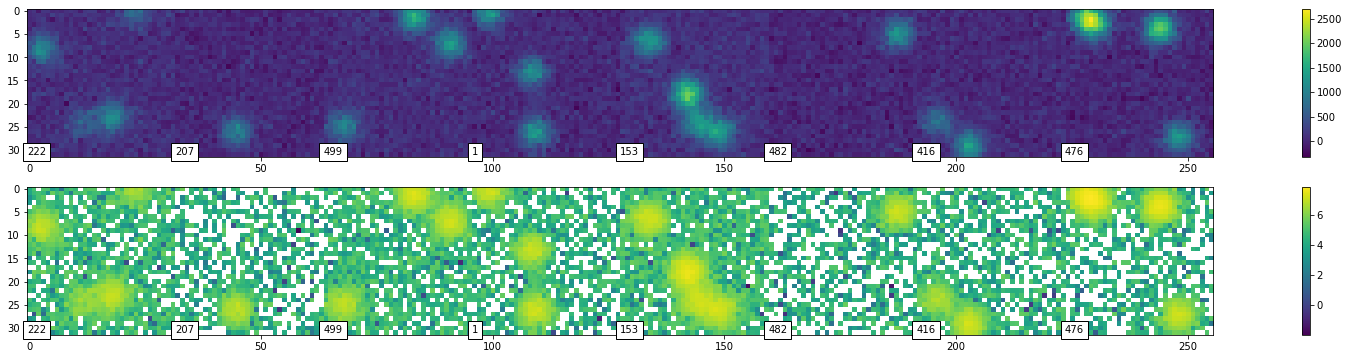

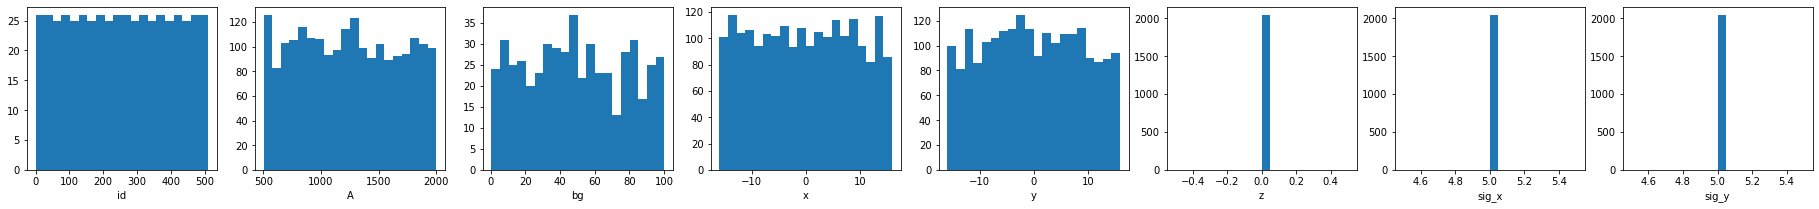

In [2]:
settings = {
    'out_size': (32,32),
    'length': (4096, 4),
    'dropout_p':0.5,
    'psf_params': {'A': [500, 2000],
                     'bg': [0, 100],
                     'x': [-16, 16],
                     'y': [-16, 16],
                    },
}

# training_data = dataset.FourierOpticsPSFDataset(**settings)
training_data = dataset.Gaussian2DPSFDataset(**settings)
training_data.to('cuda')
dataset.inspect_images(training_data)
train_dataloader = DataLoader(training_data, batch_size=2048, shuffle=True)

settings['length'] = (512, 4)
# validation_data = dataset.FourierOpticsPSFDataset(**settings)
validation_data = dataset.Gaussian2DPSFDataset(**settings)
validation_data.to('cuda')
dataset.inspect_images(validation_data)
validation_dataloader = DataLoader(validation_data, batch_size=512, shuffle=True)

In [3]:
params_ref_override = {
            'x': model.FitParameter(nn.Hardtanh(), 0, 30, 0, True),
            'y': model.FitParameter(nn.Hardtanh(), 0, 30, 0, True),
            'A': model.FitParameter(nn.ReLU(), 0., 1000, 1, True),
            'bg': model.FitParameter(nn.Tanh(), 0, 200, 0, False),
            'sig': model.FitParameter(nn.ReLU(), 1, 1, 0, False),
}

fitting_model = model.BaseFitModel(renderer_class=model.renderer.Gaussian2DRenderer,
                                   encoder_class=model.UnetEncoderModel,
                                   mapper_class=model.mapper.CentroidMapperModel,
                                   img_size=(32,32),
                                   max_psf_count=4,
                                   fit_params=['x','y','bg','A','sig'],
                                   encoder_params={
                                          "depth":3,
                                          "first_layer_out_channels":32,
                                   },
                                    params_ref_override=params_ref_override,
)

In [4]:
optimizer = torch.optim.AdamW(fitting_model.parameters(), lr=1e-5)
training = trainer.FittingTrainer(fitting_model, train_dataloader, validation_dataloader, optimizer=optimizer)

print(summary(fitting_model, input_size=(8, 1, 32, 32), row_settings=["var_names"], depth=4))

Device: cuda
Layer (type (var_name))                       Output Shape              Param #
BaseFitModel                                  --                        --
├─CentroidMapperModel (mapper)                --                        --
│    └─ModuleDict (mapping_modules)           --                        --
│    └─Centroid (centroid_module)             --                        --
├─Gaussian2DRenderer (renderer)               --                        --
├─UnetEncoderModel (encoder)                  [8, 6, 32, 32]            --
│    └─ModuleDict (encoders)                  --                        --
│    │    └─Sequential (conv_layer0)          [8, 32, 32, 32]           --
│    │    │    └─Identity (0)                 [8, 1, 32, 32]            --
│    │    │    └─Conv2d (1)                   [8, 32, 32, 32]           320
│    │    │    └─ReLU (2)                     [8, 32, 32, 32]           --
│    │    │    └─Identity (3)                 [8, 32, 32, 32]           --
│    │

Saved model to : /home/kkc29/scratch60/runs/2022-04-30_05-00-28_c18n07.farnam.hpc.yale.internal_multiemitter_test/model.ptm
Saved loss model : /home/kkc29/scratch60/runs/2022-04-30_05-00-28_c18n07.farnam.hpc.yale.internal_multiemitter_test/loss.ptm


  0%|          | 0/5000 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 999. Saved to : /home/kkc29/scratch60/runs/2022-04-30_05-00-28_c18n07.farnam.hpc.yale.internal_multiemitter_test/checkpoint.ptc
Epoch 1999. Saved to : /home/kkc29/scratch60/runs/2022-04-30_05-00-28_c18n07.farnam.hpc.yale.internal_multiemitter_test/checkpoint.ptc
Epoch 2999. Saved to : /home/kkc29/scratch60/runs/2022-04-30_05-00-28_c18n07.farnam.hpc.yale.internal_multiemitter_test/checkpoint.ptc
Epoch 3999. Saved to : /home/kkc29/scratch60/runs/2022-04-30_05-00-28_c18n07.farnam.hpc.yale.internal_multiemitter_test/checkpoint.ptc
Epoch 4999. Saved to : /home/kkc29/scratch60/runs/2022-04-30_05-00-28_c18n07.farnam.hpc.yale.internal_multiemitter_test/checkpoint.ptc


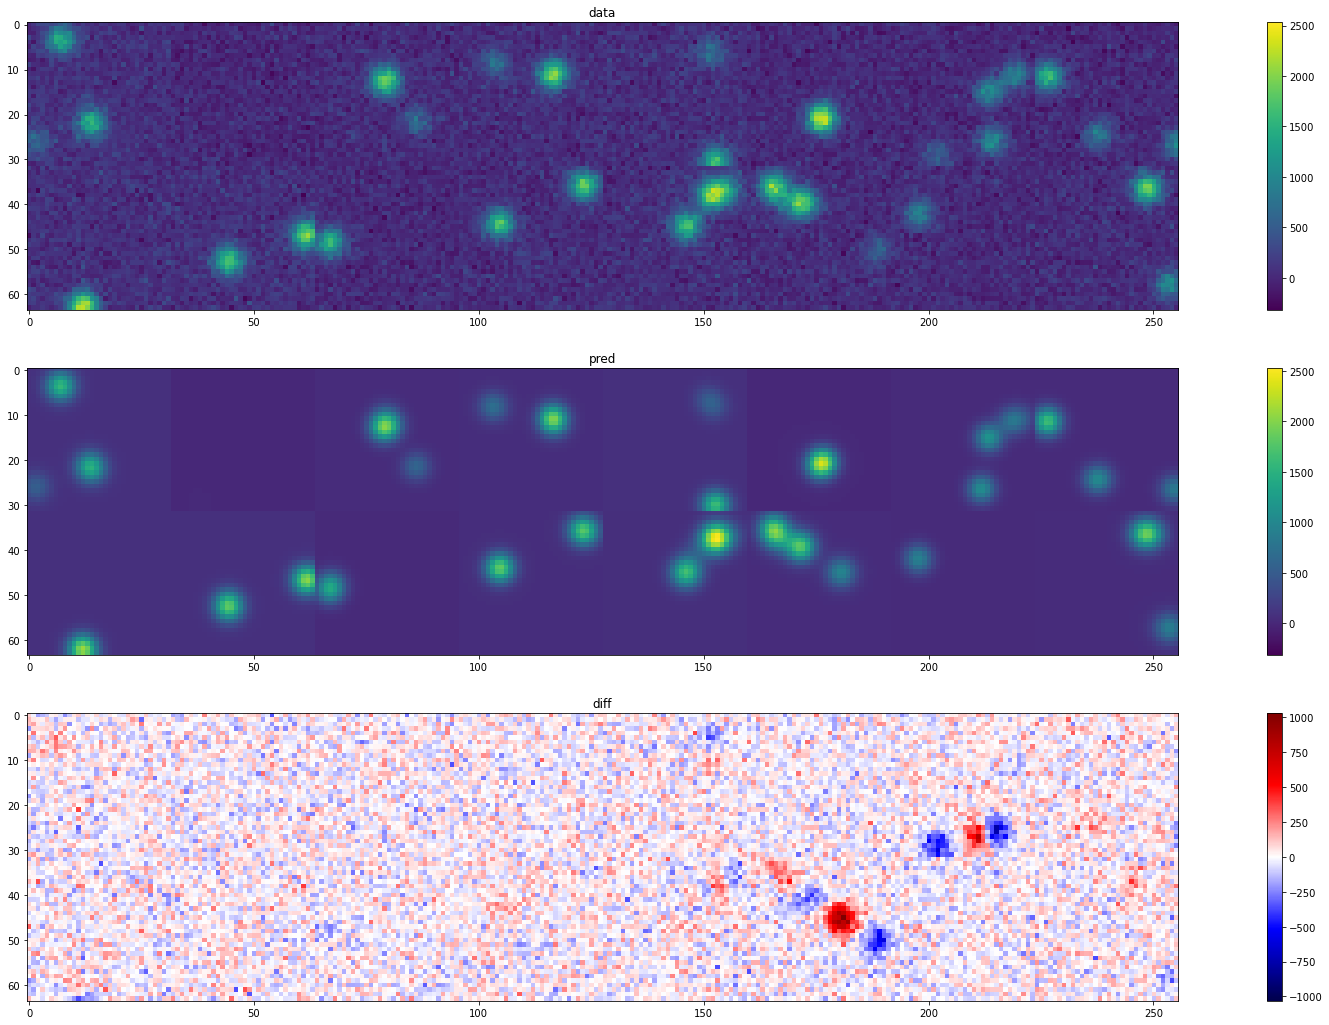

In [5]:
dict_log = {}
training.train_and_validate(5000, training_interval=10, validate_interval=100, label="multiemitter_test", tb_log_limit_images=8, dict_log=dict_log)

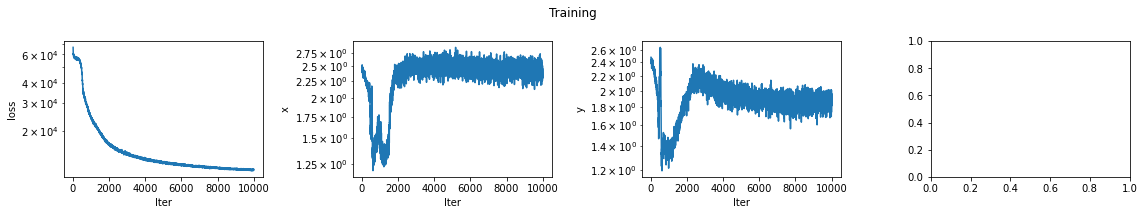

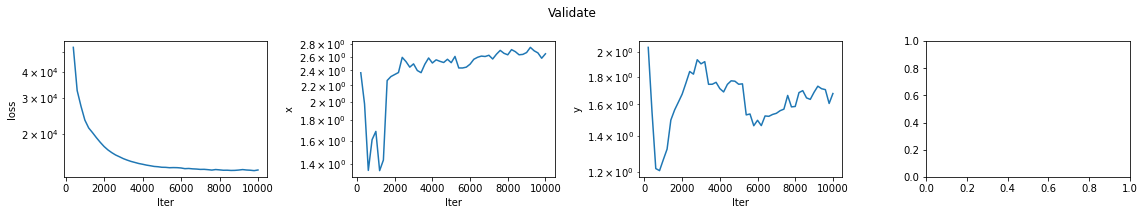

In [6]:
plots = trainer.inspect_dict_log(dict_log, log=True)